In [33]:
from matplotlib import pyplot as plt
import pandas as pd
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay,classification_report
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import time
import numpy as np
import seaborn as sns
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
from statistics import mean
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,accuracy_score
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier
from matplotlib import pyplot
from sklearn.linear_model import LogisticRegression
import pickle

## Processing Data

In [17]:
df = pd.read_csv ('ProcessedDataset.csv', sep=',')
df.columns = df.columns.str.strip()
df = df.apply(lambda x: x.str.strip() if x.dtype == 'object' else x)




#malicious_fraction = 100 * (non_malicious_count - malicious_count) / non_malicious_count
#perform undersampling as we go from 0.4% to 4%
df = df.drop(df[df['malicious'] == True].sample(frac=0.9).index)
malicious_count = df['malicious'].value_counts()[True]
non_malicious_count = df['malicious'].value_counts()[False]
smote = SMOTE(random_state=42)

X = df.drop(columns=['malicious',])
y = df['malicious']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Apply SMOTE to the training data only
X_smote, y_smote = smote.fit_resample(X_train, y_train)
print("Class distribution before SMOTE:", y_train.value_counts())
print("Class distribution after SMOTE:", pd.Series(y_smote).value_counts())

Class distribution before SMOTE: malicious
True     4596
False     182
Name: count, dtype: int64
Class distribution after SMOTE: malicious
True     4596
False    4596
Name: count, dtype: int64


## Training Multiple Models

### Training a Random Forest Model

In [27]:
srf = RandomForestClassifier(n_estimators=300, random_state=42,bootstrap= False, min_samples_split= 10,min_samples_leaf=2,max_depth= 20)
srf.fit(X_smote, y_smote)

RandomForestClassifier(bootstrap=False, max_depth=20, min_samples_leaf=2,
                       min_samples_split=10, n_estimators=300, random_state=42)

### Training a Balanced Random Forest Model

In [28]:
brf = BalancedRandomForestClassifier(n_estimators=300, random_state=42,bootstrap= False, min_samples_split= 10,min_samples_leaf=2,max_depth= 20,sampling_strategy='all',replacement=True)
brf.fit(X_smote, y_smote)

BalancedRandomForestClassifier(bootstrap=False, max_depth=20,
                               min_samples_leaf=2, min_samples_split=10,
                               n_estimators=300, random_state=42,
                               replacement=True, sampling_strategy='all')

### Training a Logistical Regression Model

In [30]:
logisticalRegression = LogisticRegression(max_iter=10000)
logisticalRegression.fit(X_smote, y_smote)

LogisticRegression(max_iter=10000)

### Evaluating Each Model

### Random Forests

0.99951171875


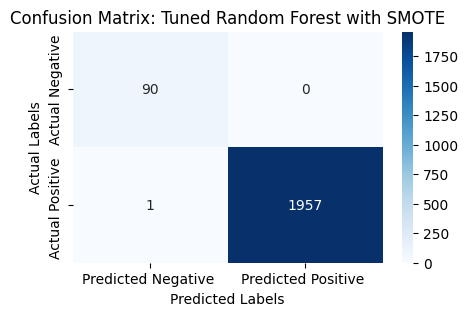

              precision    recall  f1-score   support

       False       0.99      1.00      0.99        90
        True       1.00      1.00      1.00      1958

    accuracy                           1.00      2048
   macro avg       0.99      1.00      1.00      2048
weighted avg       1.00      1.00      1.00      2048



In [40]:
y_pred_test_srf = srf.predict(X_test)
print(accuracy_score(y_test, y_pred_test_srf ))
cm=confusion_matrix(y_test, y_pred_test_srf)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Negative ', 'Predicted Positive '],
            yticklabels=['Actual Negative', 'Actual Positive '])
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix: Tuned Random Forest with SMOTE')
plt.show()
print(classification_report(y_test, y_pred_test_srf))


### Balanced Random Forests

0.9990234375


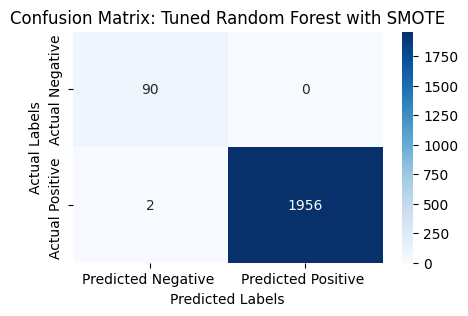

              precision    recall  f1-score   support

       False       0.98      1.00      0.99        90
        True       1.00      1.00      1.00      1958

    accuracy                           1.00      2048
   macro avg       0.99      1.00      0.99      2048
weighted avg       1.00      1.00      1.00      2048



In [41]:
y_pred_test_brf = brf.predict(X_test)
print(accuracy_score(y_test, y_pred_test_brf ))
cm=confusion_matrix(y_test, y_pred_test_brf)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Negative ', 'Predicted Positive '],
            yticklabels=['Actual Negative', 'Actual Positive '])
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix: Tuned Random Forest with SMOTE')
plt.show()
print(classification_report(y_test, y_pred_test_brf))

### Logistical Regression

0.921875


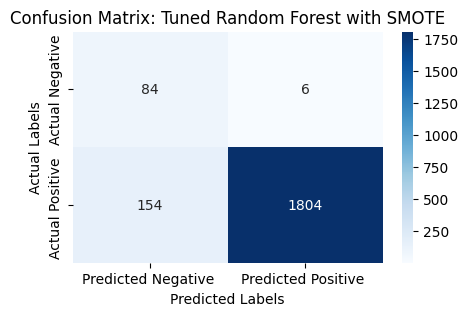

              precision    recall  f1-score   support

       False       0.35      0.93      0.51        90
        True       1.00      0.92      0.96      1958

    accuracy                           0.92      2048
   macro avg       0.67      0.93      0.73      2048
weighted avg       0.97      0.92      0.94      2048



In [42]:
y_pred_test_lrm = logisticalRegression.predict(X_test)
print(accuracy_score(y_test, y_pred_test_lrm ))
cm=confusion_matrix(y_test, y_pred_test_lrm)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Negative ', 'Predicted Positive '],
            yticklabels=['Actual Negative', 'Actual Positive '])
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix: Tuned Random Forest with SMOTE')
plt.show()
print(classification_report(y_test, y_pred_test_lrm))

## Checking the importance of each feature for the forests model

### Random Forests

Elapsed time to compute the importances: 0.026 seconds


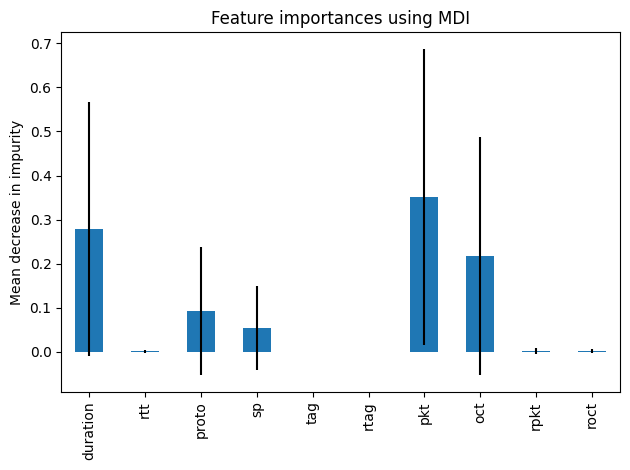

In [44]:
feature_names = [f"feature {i}" for i in range(X.shape[1])]
feature_names = X.columns

start_time = time.time()
importances = srf.feature_importances_
std = np.std([tree.feature_importances_ for tree in srf.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

rf_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
rf_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### Balanced Random Forests

Elapsed time to compute the importances: 0.026 seconds


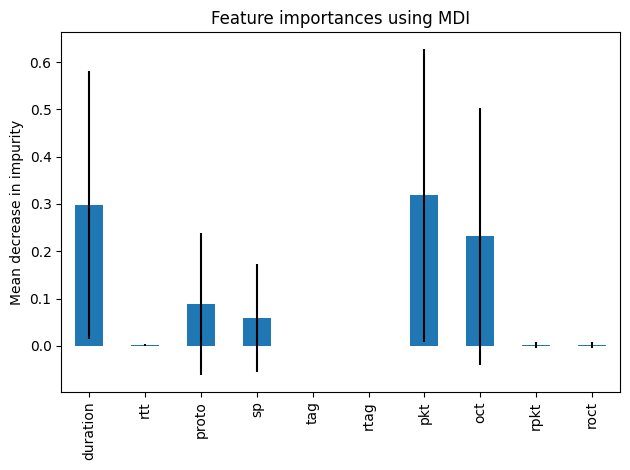

In [45]:
feature_names = [f"feature {i}" for i in range(X.shape[1])]
feature_names = X.columns

start_time = time.time()
importances = brf.feature_importances_
std = np.std([tree.feature_importances_ for tree in brf.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

rf_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
rf_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()